In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
#from sklearn.metrics import mean_squared_error, r2_score
#from sklearn.linear_model import LinearRegression
import scipy
import tellurium as te
import pandas as pd
from scipy import stats

from scipy.optimize import differential_evolution as diff_evol

class SpecialDict(dict):
    
    def values(self):
        return list(super().values())
    
from pylab import *
from scipy.optimize import curve_fit

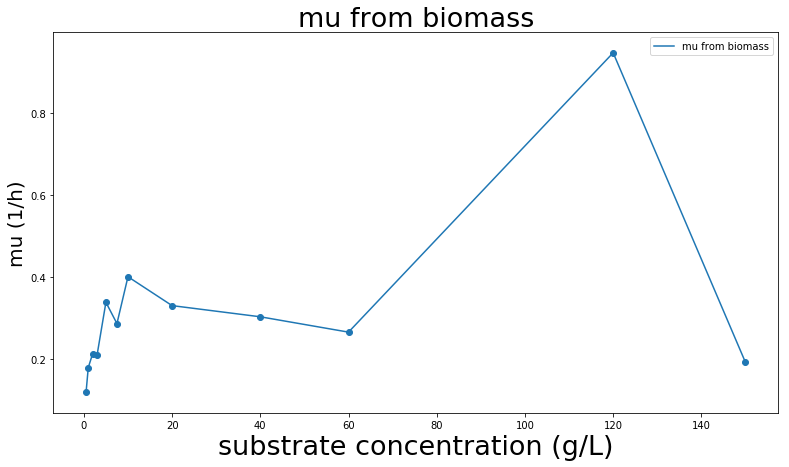

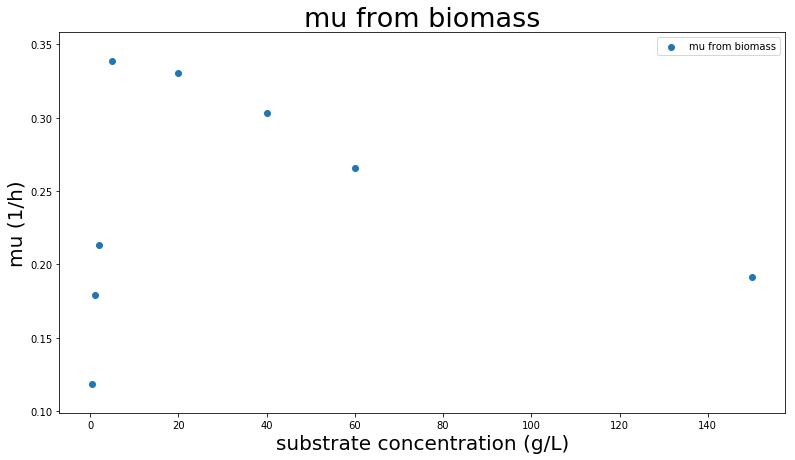

In [2]:
# The growth rate from mu biomass and corresponding substrate
mu_biomass = [0.1186, 0.1790, 0.2131, 0.2099, 0.3385, 0.2865, 0.4010, 0.3304, 0.3031, 0.2656, 0.9483, 0.1916]
substrate_initial = [0.5, 1.0, 2.0, 3.0, 5.0, 7.5, 10.0, 20.0, 40.0, 60.0, 120.0, 150.0]

plt.figure(1,figsize=(13, 7))
plt.scatter(substrate_initial,mu_biomass)
plt.plot(substrate_initial,mu_biomass)
plt.legend(['mu from biomass'], loc='upper right')
plt.ylabel('mu (1/h)', fontsize = 20)
plt.xlabel('substrate concentration (g/L)', fontsize = 27)
plt.title('mu from biomass', fontsize = 27)
plt.savefig('figures/kinetics/mu_vs_sub_all_data.png')

plt.show()

# I delete point 4 and 6 since they are outliners and must be due to some measurement errors.

# Then we get the data
mu_biomass = [0.1186, 0.1790, 0.2131, 0.3385, 0.3304, 0.3031, 0.2656, 0.1916]
substrate_initial = [0.5, 1.0, 2.0, 5.0, 20.0, 40.0, 60.0, 150.0]

plt.figure(1,figsize=(13, 7))
plt.scatter(substrate_initial,mu_biomass)
plt.legend(['mu from biomass'], loc='upper right')
plt.ylabel('mu (1/h)', fontsize = 20)
plt.xlabel('substrate concentration (g/L)', fontsize = 20)
plt.title('mu from biomass', fontsize = 27)
plt.savefig('figures/kinetics/mu_vs_sub.png')

plt.show()

## Linear regression using 95 % confidence interval  

[2.86313491 2.76788463]
[0.32656997 0.37555546] standard deviation


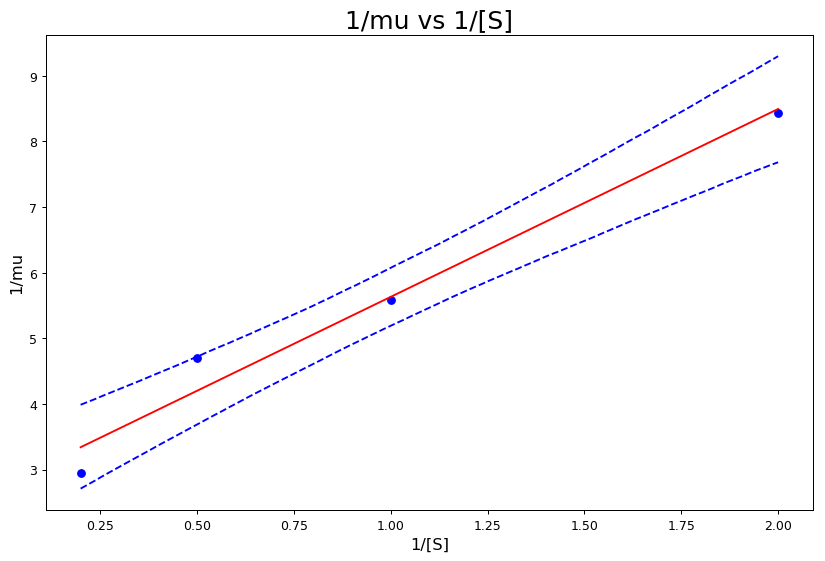

0.9746403509191104
2.767884627874524


In [13]:
mu_biomass = [0.1186, 0.1790, 0.2131, 0.3385]
substrate_initial = [0.5, 1.0, 2.0, 5.0]

mu_biomass = np.divide(1,mu_biomass)
substrate_initial = np.divide(1,substrate_initial)

x = substrate_initial
y = mu_biomass

def f(x, a, b):
    return a*x + b



# The following returns p from the fitted curve which consists of the intercept and slope 
# and returns the covarians matrix. The function curve_fit is from scipy optimize.
p, pcov = curve_fit(f, x, y)
print(p)


# The diagonals in covariance is the variance of the parameter estimation. 
# Then we can compute the standard deviation on the parameters with ->
perr = np.sqrt(np.diag(pcov))
print(perr, 'standard deviation')

# I create evenly spaced numbers from the minimum value of x to the maximum value of x. 
# and ps are samples that are drawn from a normal multivariate distribution around the mean (which is the slope and intercept), and covariance matrix (). 
# Then creates samples around the intercept and the slope value. 
xi = linspace(np.min(x), np.max(x), 100)
ps = np.random.multivariate_normal(p, pcov, 10000)

# This creates (10000,100) array i.e. 100 y samples pr. set of slope and intercept sample, so 100 samples 10000 times. 
# In percentile axis 0 means it takes the values in the column, order it from lowest to highest then multiply 0.025*10.000 test scores for the lower confidence interval. 
ysample = np.asarray([f(xi, *pi) for pi in ps])
lower = np.percentile(ysample, 2.5, axis=0)
upper = np.percentile(ysample, 97.5, axis=0)


plt.figure(num=None, figsize=(11, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(x, y, 'bo')
plt.plot(x, p[1] + p[0]*x, 'r-')
plt.plot(xi, lower, 'b--')
plt.plot(xi, upper, 'b--')
plt.ylabel('1/mu',fontsize = 13)
plt.xlabel('1/[S]',fontsize = 13)
plt.title('1/mu vs 1/[S]',fontsize = 20)
plt.savefig('figures/kinetics/invmu_vs_invsub.png')
plt.show()


SSE = np.sum((y - (p[1] + p[0]*x))**2)
SST = np.sum((y - mean(y))**2)
r_squared = 1 - (SSE/SST)
print(r_squared)
print(p[1])

In [83]:
# This means that the intercept = 1/mu_max 
# Therefore mu_max is 
mu_max = 1/p[1] 
print(mu_max)

# The slope = Ks/mu_max =>  mu_max*slope = Ks
Ks = mu_max*p[0] 
print(Ks) 

0.3938169998098728
1.1879438987676527


## Estimation of Ki

In [7]:
mu_biomass = [0.1186, 0.1790, 0.2131, 0.3385, 0.3304, 0.3031, 0.2656, 0.1916]
substrate_initial = [0.5, 1.0, 2.0, 5.0, 20.0, 40.0, 60.0, 150.0]

mu_data = pd.DataFrame()
mu_data['mu'] = mu_biomass
mu_data['substrate'] = substrate_initial

mu_data.to_csv('estimation/mu_data.csv')

In [128]:
# At large substrate concentration inhibition occur. The Ki constant is determined by estimating the parameter, based on the mu data and the model

# the time here is the substrate concentration (this is just because tellurium and copasi operates in time, I just pretend that it is substrate, 
# because mu is a function of substrate concentration)

# The model has fixed values for mu_max and Ks and estimated Ki

mu_model = '''
model *IDModel()

    ######## Set the compartment to 1, otherwise it will be multiplied by the compounds. 
    compartment comp1;
    comp1 =1;


    ######## Specify the species in the compartment
    mu in comp1; 


    ######## Constants
    mu_max = 0.3938
    Ks = 1.1879
    Ki = 141.5910 # should be estimated


    ######## Functions
    
    mu := mu_max*time/((time+Ks)+(time^2/Ki)) # [1/h]

    end
'''

r = te.loada(mu_model)

r.exportToSBML('estimation/mu_model.xml')
r.timeCourseSelections = ['time', 'mu']
results = r.simulate(0.5, 150, 100) 

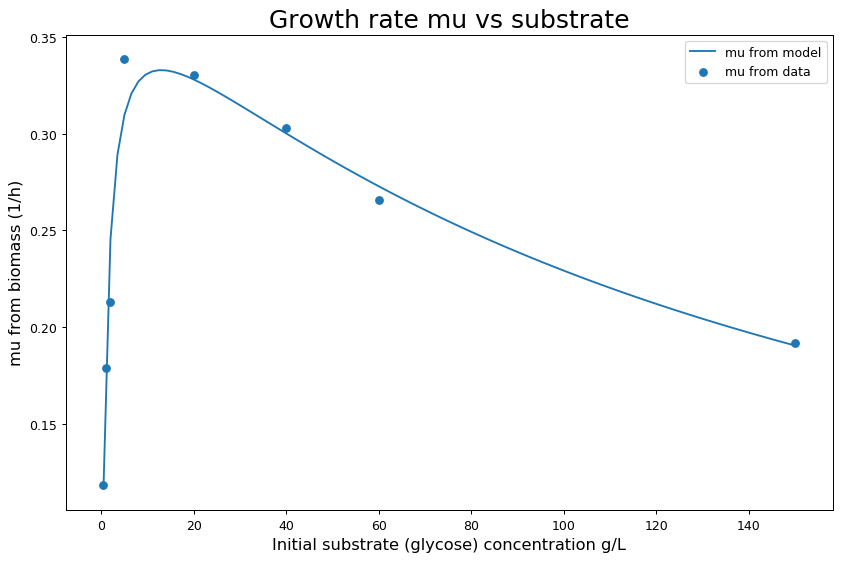

In [129]:
plt.figure(num=None, figsize=(11, 7), dpi=90, facecolor='w', edgecolor='k')

plt.plot(results[:, 0], (results[:, 1]))
plt.scatter(substrate_initial, mu_biomass)
plt.legend(['mu from model', 'mu from data'], loc='upper right')
plt.xlabel('Initial substrate (glycose) concentration g/L', fontsize = 13)
plt.ylabel('mu from biomass (1/h)', fontsize = 13)
plt.title('Growth rate mu vs substrate', fontsize = 20)
plt.savefig('figures/kinetics/modelmu_vs_sub.png')
plt.show()

# One could also use this method by only using scipys curve fit and fitting all data 

[  0.41562776   1.40025227 119.99552864]
[ 0.02879903  0.26903259 28.48207682] standard deviation


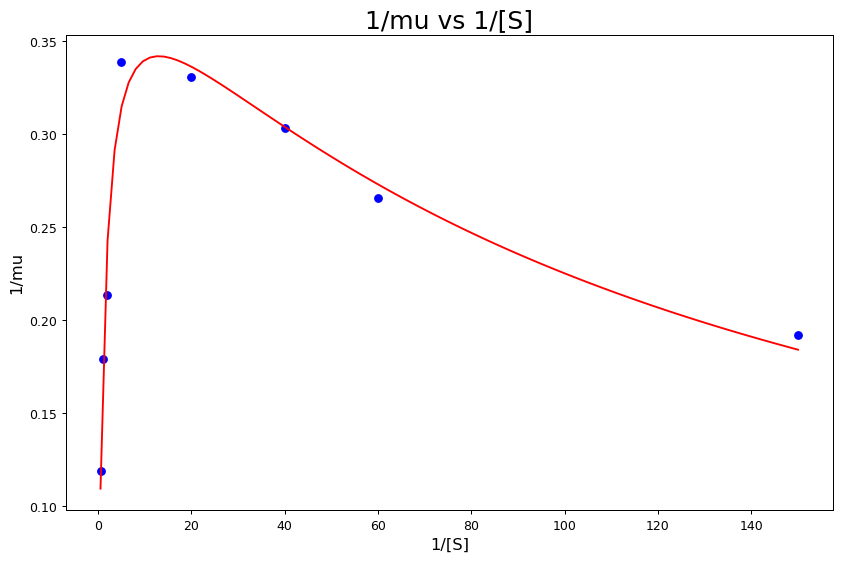

0.10454055364466963


In [12]:
mu_biomass = [0.1186, 0.1790, 0.2131, 0.3385, 0.3304, 0.3031, 0.2656, 0.1916]
substrate_initial = [0.5, 1.0, 2.0, 5.0, 20.0, 40.0, 60.0, 150.0]


x = substrate_initial
y = mu_biomass

def func(x, mu_max, Ks, Ki):
    return  mu_max*x/((x+Ks)+(x**2/Ki))

# The following returns p from the fitted curve which consists of the intercept and slope 
# and returns the covarians matrix. The function curve_fit is from scipy optimize.
p, pcov = curve_fit(func, x, y)
print(p)

# The diagonals in covariance is the variance of the parameter estimation. 
# Then we can compute the standard deviation on the parameters with ->
perr = np.sqrt(np.diag(pcov))
print(perr, 'standard deviation')


x = pd.DataFrame(x)
xi = linspace(np.min(x), np.max(x), 100)

plt.figure(num=None, figsize=(11, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(x, y, 'bo')
plt.plot(xi, p[0]*xi/((xi+p[1])+(xi**2/p[2])), 'r-')
plt.ylabel('1/mu',fontsize = 13)
plt.xlabel('1/[S]',fontsize = 13)
plt.title('1/mu vs 1/[S]',fontsize = 20)
plt.show()

x = np.array(x)

SSE = np.sum((y - (p[0]*x/((x+p[1])+(x**2/p[2])))))
SST = np.sum((y - mean(y))**2)
r_squared = 1 - (SSE/SST)
print(r_squared)